In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [40]:
mnist = input_data.read_data_sets('../gan/MNIST_data/', one_hot=True)

Extracting ../gan/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../gan/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../gan/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../gan/MNIST_data/t10k-labels-idx1-ubyte.gz


In [61]:
class NeuralNetWork(object):
    def __init__(self, initial_weights, activation_fn, use_batch_normal):
        self.use_batch_normal = use_batch_normal
        self.name = 'With Batch Normal' if use_batch_normal else "Without Batch Normal"
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        self.training_accuracy = []
        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):
        self.input_layer = tf.placeholder(tf.float32, shape=(None, initial_weights[0].shape[0]))
        layer_in = self.input_layer
        #不计入输出层
        for layer_weights in initial_weights[:-1]:
            layer_in = self.fully_connected_layer(layer_in, layer_weights, activation_fn)
        #计算输出层
        self.output_layer = self.fully_connected_layer(layer_in, initial_weights[-1])
        
    def fully_connected_layer(self, inputs, layer_weights, activation_fn=None):
        if self.use_batch_normal and activation_fn:
            weights = tf.Variable(layer_weights)
            linear_ouput = tf.matmul(inputs, weights)
            batch_output = tf.layers.batch_normalization(linear_ouput, training=self.is_training)
            return activation_fn(batch_output)
        else:
            weights = tf.Variable(layer_weights)
            bias = tf.Variable(tf.zeros(layer_weights.shape[-1]))
            linear_ouput = tf.add(tf.matmul(inputs, weights), bias)
            return activation_fn(linear_ouput) if activation_fn else linear_ouput
    
    def train(self, sess, learning_rate, train_batches, valid_batches, save_model=None):
        labels = tf.placeholder(tf.float32, shape=[None, 10])
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,logits=self.output_layer)
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        if self.use_batch_normal:
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        for i in tqdm(range(train_batches)):
            batch_x, batch_y = mnist.train.next_batch(60)
            _ = sess.run(optimizer, feed_dict={self.input_layer:batch_x, labels:batch_y, self.is_training:True})
            if i % valid_batches == 0:
                val_accuracy = sess.run(accuracy, feed_dict={self.input_layer:mnist.validation.images,
                                                            labels:mnist.validation.labels,
                                                            self.is_training:False})
                self.training_accuracy.append(val_accuracy)
        print('{}:The final accuracy in validation data is {}'.format(self.name, val_accuracy))
        if save_model:
            tf.train.Saver().save(sess, save_model)
    
    def test(self, sess, restore=None):
        labels = tf.placeholder(tf.float32, shape=[None,10])
        
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        if restore:
            tf.train.Saver.restore(sess, restore)
        
        test_accuracy = sess.run(accuracy, feed_dict={self.input_layer:mnist.test.images,
                                                     labels:mnist.test.labels,
                                                     self.is_training:False})
        print('{} :The final accuracy in test data is {}'.format(self.name, test_accuracy))

            

In [68]:
#接下来构建辅助函数去评测上面的结果
def plot_training_accuracies(*args, valid_batches):
    """
    绘制模型在训练过程中的准确率曲线
    
    :param args: 一个或多个NeuralNetWork对象
    :param batches_per_validate_data: 训练多少个batch进行一次数据验证
    """
    fig, ax = plt.subplots()
    
    for nn in args:
        im = ax.plot(range(0, len(nn.training_accuracy)*valid_batches, valid_batches),
                nn.training_accuracy, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

In [69]:
def train_and_test(use_large_weights, activation_fn, learning_rate, train_batches=5000, valid_batches=50):
    if use_large_weights:
        weights = [np.random.normal(size=(784, 128), scale=10.0).astype(np.float32),
                  np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,128), scale=10.0).astype(np.float32),
                   np.random.normal(size=(128,10), scale=10.0).astype(np.float32)]
    else:
        weights = [np.random.normal(size=(784, 128), scale=0.05).astype(np.float32),
                  np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,128), scale=0.05).astype(np.float32),
                   np.random.normal(size=(128,10), scale=0.05).astype(np.float32)]
    tf.reset_default_graph()
    nn = NeuralNetWork(weights, activation_fn, use_batch_normal=False)
    bn = NeuralNetWork(weights, activation_fn, use_batch_normal=True)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print("【Training Result:】\n")
        
        nn.train(sess, learning_rate, train_batches, valid_batches)
        bn.train(sess, learning_rate, train_batches, valid_batches)
        
        print("\n【Testing Result:】\n")
        nn.test(sess)
        bn.test(sess)
    
    plot_training_accuracies(nn, bn, valid_batches=valid_batches)
        

  0%|          | 8/5000 [00:00<01:03, 78.69it/s]

【Training Result:】



100%|██████████| 5000/5000 [00:19<00:00, 256.37it/s]


Without Batch Normal:The final accuracy in validation data is 0.9751999974250793


100%|██████████| 5000/5000 [00:33<00:00, 150.96it/s]


With Batch Normal:The final accuracy in validation data is 0.9832000136375427

【Testing Result:】

Without Batch Normal :The final accuracy in test data is 0.9725000262260437
With Batch Normal :The final accuracy in test data is 0.9779000282287598


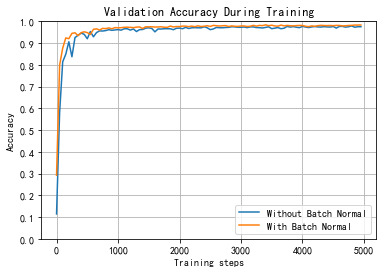

In [70]:
train_and_test(use_large_weights=False, learning_rate=0.01, activation_fn=tf.nn.relu)